# Encoder-Decoder to translate english to spanish words

In [ ]:
import tensorflow as tf

In [ ]:
from pathlib import Path
url = 'https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets", extract=True)

text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

2638744/2638744 [==============================] - 0s 0us/step


In [ ]:
# remove spanish characters
import numpy as np
text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]

pairs[:5]

[['Go.', 'Ve.'],
 ['Go.', 'Vete.'],
 ['Go.', 'Vaya.'],
 ['Go.', 'Váyase.'],
 ['Hi.', 'Hola.']]

In [ ]:
np.random.shuffle(pairs)

sentences_en, sentences_es = zip(*pairs) # separates pairs into 2 lists
sentences_en[:5], sentences_es[:5]

(('She is a nurse.',
  'Do you want to come along with us?',
  "I'm ready to go.",
  'This tie goes well with the suit, I guess.',
  "We're rich."),
 ('Ella es una enfermera.',
  'Quieres venir con nosotras?',
  'Estoy listo para irme.',
  'Supongo que esta corbata queda bien con el traje.',
  'Somos ricos.'))

In [ ]:
for i in range(3):
  print(sentences_en[i], "==>", sentences_es[i])

She is a nurse. ==> Ella es una enfermera.
Do you want to come along with us? ==> Quieres venir con nosotras?
I'm ready to go. ==> Estoy listo para irme.


Create 2 textVectorization Layers - one per language

In [ ]:
vocab_size=1_000
max_length = 50

text_vec_layer_en = tf.keras.layers.TextVectorization(vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(vocab_size, output_sequence_length=max_length)

text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es]) # this is for the decoder, without it the decoder wouldnt know when to start the translation

In [ ]:
# visualize
print(text_vec_layer_es.get_vocabulary()[:10])
print(text_vec_layer_en.get_vocabulary()[:10])

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']
['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']


In [ ]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])

X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])

y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [ ]:
len(X_train), len(X_valid)

(100000, 18964)

In [ ]:
# Reducing the size of the training and validation sets
train_size = 5_000  # Example size, adjust as needed
valid_size = 1_000   # Example size, adjust as needed

X_train = tf.constant(sentences_en[:train_size])
X_valid = tf.constant(sentences_en[train_size:train_size + valid_size])

X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:train_size]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[train_size:train_size + valid_size]])

y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:train_size]])
y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[train_size:train_size + valid_size]])


In [ ]:
len(X_train), len(X_valid)

(5000, 1000)

In [ ]:
X_train[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'She is a nurse.', b'Do you want to come along with us?',
       b"I'm ready to go.", b'This tie goes well with the suit, I guess.',
       b"We're rich."], dtype=object)>

Since the model is not sequential, need to use the functional tensorflow api

In [ ]:
# requires 2 text inputs, one for encoder and one for decoder

encoder_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="input_encoder")

decoder_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="input_decoder")

In [ ]:
# need to encode these sentences use TextVectorization layers we prepared earlier, followed by an embedding layer for each language with mask_zero=True to ensure masking is handled automatically

embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)

encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    embed_size,
                                                    mask_zero=True)

encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

Now create encoder and pass it the embedded inputs

Since we're using LSTM, there are 2 states:
* short term state
* long term state

The layer returns these states separately which is why we had to write *encoder_state to group both states in a list:

In [ ]:
# to keep simple just used a single LSTM layer but you could stack several of them
encoder = tf.keras.layers.LSTM(512, return_state=True) # return_state to get a reference to the layers final state
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [ ]:
# use the encoder_state as the intial state of the decoder
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [ ]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
y_proba = output_layer(decoder_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[y_proba])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_encoder (InputLayer)  [(None,)]                    0         []                            
                                                                                                  
 input_decoder (InputLayer)  [(None,)]                    0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 50)                   0         ['input_encoder[0][0]']       
 ctorization)                                                                                     
                                                                                                  
 text_vectorization_1 (Text  (None, 50)                   0         ['input_decoder[0][0]'] 

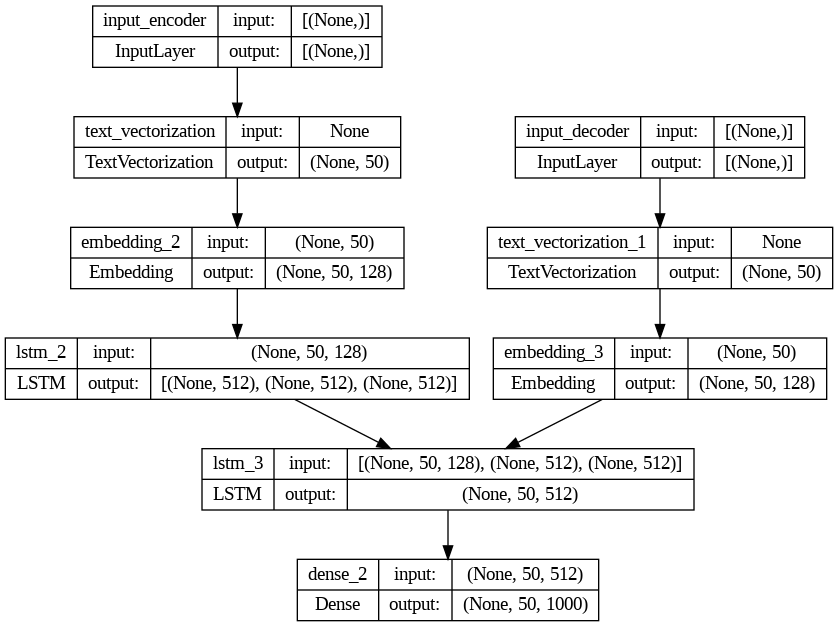

In [ ]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
# fit the model
model.fit((X_train, X_train_dec),
          y_train,
          validation_data=((X_valid, X_valid_dec), y_valid),
          epochs=10)

Epoch 1/10
157/157 [==============================] - 276s 2s/step - loss: 4.4873 - accuracy: 0.2685 - val_loss: 4.1293 - val_accuracy: 0.2943
Epoch 2/10
157/157 [==============================] - 263s 2s/step - loss: 3.9820 - accuracy: 0.3082 - val_loss: 3.8853 - val_accuracy: 0.3142
Epoch 3/10
157/157 [==============================] - 263s 2s/step - loss: 3.7019 - accuracy: 0.3313 - val_loss: 3.6568 - val_accuracy: 0.3341
Epoch 4/10
157/157 [==============================] - 263s 2s/step - loss: 3.4268 - accuracy: 0.3540 - val_loss: 3.4810 - val_accuracy: 0.3468
Epoch 5/10
157/157 [==============================] - 251s 2s/step - loss: 3.2192 - accuracy: 0.3729 - val_loss: 3.3813 - val_accuracy: 0.3608
Epoch 6/10
157/157 [==============================] - 263s 2s/step - loss: 3.0264 - accuracy: 0.3924 - val_loss: 3.2889 - val_accuracy: 0.3743
Epoch 7/10
157/157 [==============================] - 252s 2s/step - loss: 2.8354 - accuracy: 0.4166 - val_loss: 3.1996 - val_accuracy: 0.3897

In [ ]:
def translate(sentence_en):
  translation = ""
  for word_idx in range(max_length):
    X = np.array([sentence_en]) # encoder input
    X_dec = np.array(["startofseq " + translation]) # decoder input
    y_proba = model.predict((X, X_dec))[0, word_idx]
    predicted_word_id = np.argmax(y_proba)
    predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
    if predicted_word == "endofseq":
      break
    translation += " " + predicted_word
  return translation.strip()

In [ ]:
translate("I like soccer and going to the beach")

1/1 [==============================] - 0s 106ms/step


'yo me [UNK] a mi fiesta esta noche'